# Library Initialization

In [35]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import xgboost as xgb
from sklearn.model_selection import train_test_split
import empyrical
from pypfopt.efficient_frontier import EfficientFrontier
from sklearn import linear_model
import Machine_Learning_Portfolio
import time

# Data Imports

In [2]:
tickers = ["GE", "PFE","SBUX", "GME", "DAL", "AAPL", "GOOGL" ]
stocks = pd.concat([yf.Ticker(i).history(period = "max")["Close"].pct_change().dropna().rename(i) for i in tickers], axis=1, join = 'inner')


In [144]:
days = 30
#Means

X1 = stocks.resample(str(days)+"d").mean()
X2 = stocks.resample(str(days)+"d").mean().shift(1).dropna()
Y = stocks.resample(str(days)+"d").mean().shift(2).dropna()
X2 = X2.iloc[:-1]
X1 = X1.iloc[:-2]
X1 = np.vstack((X1[col].values.reshape(-1,1) for col in X1.columns))
X2 = np.vstack((X2[col].values.reshape(-1,1) for col in X2.columns))
X = np.hstack((X1, X2))
Y = np.vstack((Y[col].values.reshape(-1,1) for col in Y.columns)).flatten()
#Covar


<ipython-input-144-e7b88e1eb916>:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X1 = np.vstack((X1[col].values.reshape(-1,1) for col in X1.columns))
<ipython-input-144-e7b88e1eb916>:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X2 = np.vstack((X2[col].values.reshape(-1,1) for col in X2.columns))
<ipython-input-144-e7b88e1eb916>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Y = np.vstack((Y[col].values.reshape(-1,1) for col in Y.columns)).flatten()


# Ridge CV Regression Model

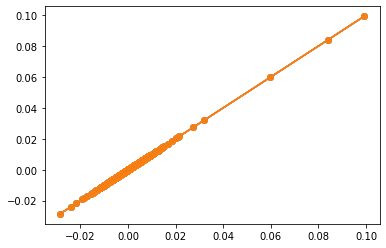

In [146]:
model = linear_model.LinearRegression()
model.fit(X, Y)
y_pred = model.predict(X)
plt.plot(X, y_pred)
plt.scatter(X[:,0], Y)
plt.scatter(X[:,0], Y)

In [10]:
X.shape

(7133, 2)

In [9]:
Y

array([-2.32077466e-03, -9.54066456e-04, -2.07843997e-05, ...,
        2.02266972e-02,  1.30123660e-02, -4.21848362e-03])

# Mean-Variance Optimization Function

In [147]:

X_sample = stocks.resample(str(days)+"d").mean()
dates = X_sample.index[1:-1]
portfolio = pd.DataFrame()

saved_weights = []
r0s = []
failed_dates = []
for day in dates[2:]: 
    sample_1 = stocks[day-pd.offsets.DateOffset(days = 2*days):day-pd.offsets.DateOffset(days=days-1)]
    sample_2 = stocks[day-pd.offsets.DateOffset(days = days):day-pd.offsets.DateOffset(days=1)]
    X1 = sample_1.mean().values.reshape(-1,1)
    X2 = sample_2.mean().values.reshape(-1,1)
    X_data = np.hstack((X1, X2))
    #sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]
    #Using Previous Data:
    #mean = sample.mean(axis=0)
    mean = pd.Series(model.predict(X_data), index = sample_1.columns)
    covar = sample_2.cov()
    
    try:
        weights_vector = [EfficientFrontier(mean,covar).max_sharpe()[ticker] for ticker in stocks.columns]
    except:
        weights_vector = [EfficientFrontier(mean,covar).max_quadratic_utility()[ticker] for ticker in stocks.columns]
        failed_dates.append(day)
        
    portfolio = pd.concat([portfolio,stocks[day:day+pd.offsets.DateOffset(days=days-1)].dot(weights_vector)])
    saved_weights.append(weights_vector)
portfolio = portfolio.sort_index()
saved_weights = pd.DataFrame(saved_weights, index = dates[2:], columns = tickers)

In [149]:
#len(failed_dates)
len(dates[2:])

167

In [132]:
portfolio_weights = empyrical.sharpe_ratio(portfolio)
equal_weights = empyrical.sharpe_ratio(stocks.mean(axis=1))
print((portfolio_weights, equal_weights))

(array([0.83574068]), 0.8126881685263265)


<AxesSubplot:xlabel='Date'>

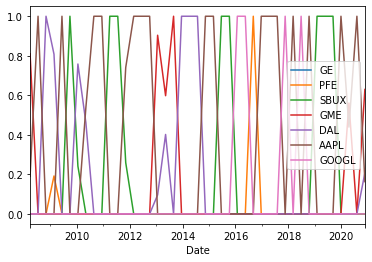

In [134]:
saved_weights.plot()
